<a href="https://colab.research.google.com/github/aevangeline/forensics/blob/master/10701_Work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Aurelia and Caroline - 10701

In [0]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [0]:
!pip install --extra-index-url https://developer.download.nvidia.com/compute/redist/cuda/10.0 nvidia-dali

Looking in indexes: https://pypi.org/simple, https://developer.download.nvidia.com/compute/redist/cuda/10.0


In [0]:
from zipfile import ZipFile
import pathlib
from urllib.request import urlretrieve
from collections import defaultdict
import os
from os import remove
import os.path
import numpy as np
import pandas as pd
import shutil as sh
import torch
import glob
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
import nvidia.dali.ops as ops
import nvidia.dali.types as types
from nvidia.dali.pipeline import Pipeline
from nvidia.dali.plugin.pytorch import DALIClassificationIterator as PyTorchIterator
from random import shuffle, random
import math
import time
import csv
import copy

from IPython.display import display, HTML
js = ('<script>function ConnectButton(){ '
        'console.log("Connect pushed"); '
        'document.querySelector("#connect").click()} '
        'setInterval(ConnectButton,3000);</script>')
display(HTML(js))


In [0]:
FID_DIRECTORY = pathlib.Path("FID-300")
FID_LABELS = FID_DIRECTORY / "label_table.csv"
FID_SOURCE_URL = "https://fid.dmi.unibas.ch/FID-300.zip"
TRAIN_DIR = "FID-300/references/"
TEST_DIR = "FID-300/tracks_cropped/"
NUM_EPOCHS = 100
NUM_CLASSES = 1175
INPUT_SIZE = 224
BATCH_SIZE = 64
MODEL_NAME = "vgg"
FEATURE_EXTRACT=False
USE_PRETRAINED=False
db_folder = pathlib.Path(TRAIN_DIR)

In [0]:
def fetch_FID_300_data():
    """Downloads and extracts FID-300 data to a local folder"""
    if FID_DIRECTORY.exists():
        print("FID-300 Database already exists")
        return
    print("Downloading FID_300")
    local_file, _ = urlretrieve(FID_SOURCE_URL)
    with ZipFile(local_file) as archive:
        print("Extracting FID-300")
        archive.extractall()
    remove(local_file)

fetch_FID_300_data()

FID-300 Database already exists


In [0]:
class ExternalInputIterator(object):
    def __init__(self, batch_size, image_dir, repeat = 32):
        self.images_dir = pathlib.Path(image_dir)
        self.images = list(glob.iglob(str(self.images_dir/"*"))) 
        self.batch_size = batch_size 
        self.repeat = repeat
        self.queue = self.images * self.repeat
        shuffle(self.queue)
        self.i = 0  

    def __iter__(self):
        self.i = 0
        shuffle(self.queue)
        return self

    @property
    def size(self,):
      return len(self.images) * self.repeat

    def __next__(self):
        batch = []
        labels = []
        if self.i >= len(self.queue):
          raise StopIteration
        for _ in range(self.batch_size):
          while self.i >= len(self.queue):
            self.i -= 1
          img = self.queue[self.i]
          fname = pathlib.Path(img)
          label = np.array(int(fname.stem) - 1, dtype = np.uint8)
          with open(fname, 'rb') as f:
            buff = np.frombuffer(f.read(), dtype = np.uint8)
            batch.append(buff)
          labels.append(label)
          self.i += 1    
        return (batch, labels)

    next = __next__

In [0]:
class AugmentationPipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id = 0,
                 examples_per_image = 1000, folder = db_folder,
                 pipelined = True, exec_async = True):
        super(AugmentationPipeline, self).__init__(batch_size, num_threads,
                                                   device_id, seed = 12,
                                                   exec_pipelined=pipelined,
                                                   exec_async=exec_async)
        self.external_data = ExternalInputIterator(batch_size,
                                                   folder,
                                                   examples_per_image)
        self.input = ops.ExternalSource()
        self.input_label = ops.ExternalSource()
        self.iterator = iter(self.external_data)
        self.decode = ops.ImageDecoderRandomCrop(device = "mixed", output_type = types.RGB,
            random_aspect_ratio=[0.8, 1.25],
            random_area=[0.6, 1.0],
            num_attempts=100)
        self.augmentations = {}
        # input is sampled randomly for output pixel's neighbourhood
        self.augmentations["jitter"] = (0.3, ops.Jitter(device = "gpu"))
        # transforms sampling coordinates to produce wavy patterns
        self.augmentations["water"] = (0.2, ops.Water(device = "gpu"))
        # applies fisheye distortion
        self.augmentations["sphere"] = (0.3, ops.Sphere(device = "gpu"))
        # rotates the image, enlarging the canvas
        self.rotation_rng = ops.Uniform(range=(-180.00, 180.00))
        self.rotate = ops.Rotate(device = "gpu",
                                 interp_type = types.INTERP_LINEAR,
                                 fill_value = 0)
        # param resizes the image so that the shorter edge is exactly 400px long
        self.resize = ops.Resize(device = "gpu", resize_x = INPUT_SIZE, resize_y = INPUT_SIZE)
        # param flips the image
        self.flip_rng = ops.CoinFlip()
        self.hflip_rng = ops.CoinFlip()
        self.flip = ops.Flip(device = "gpu")
        self.bri_con_rng = ops.Uniform(range = (.5, 2))
        self.saturation_rng = ops.Uniform(range = (.2, 1))
        self.color_twist = ops.ColorTwist(device = "gpu")
        self.iter = 0

    def define_graph(self):
        self.jpegs = self.input(name="Reader")
        self.labels = self.input_label(name="Reader")
        output_labels = []
        images = self.decode(self.jpegs).gpu()
        transformed = images
        for thresh, op in self.augmentations.values():
          if random() < thresh:
            transformed = op(images)
        #transformed = self.flip(transformed,
        #                        vertical = self.flip_rng(),
        #                        horizontal = self.hflip_rng())
        transformed = self.rotate(transformed, angle = self.rotation_rng())
        #transformed = self.color_twist(transformed, brightness=self.bri_con_rng(),
        #                                contrast=self.bri_con_rng(),
        #                                saturation=self.saturation_rng())
        transformed = self.resize(transformed)
        return (transformed, self.labels)

    @property
    def iter_size(self,):
      return self.external_data.size


    def iter_setup(self):
      try:
        (images, labels) = self.iterator.next()
        self.feed_input(self.jpegs, images)
        self.feed_input(self.labels, labels)
      except StopIteration:
        self.iterator = iter(self.external_data)
        raise StopIteration
      


In [0]:
def process_images():
    transformations = transforms.Compose([
        transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                             0.229, 0.224, 0.225])
    ])

    train_pipe = AugmentationPipeline(BATCH_SIZE, 8, examples_per_image=10)
    train_pii = PyTorchIterator(train_pipe,
                                          size=train_pipe.iter_size,
                                          last_batch_padded=True,
                                          fill_last_batch=True)
    validate_pipe = AugmentationPipeline(BATCH_SIZE, 8, examples_per_image=1)
    validate_pii = PyTorchIterator(validate_pipe,
                                             size=validate_pipe.iter_size,
                                             last_batch_padded=True,
                                             fill_last_batch=True)

    test_data = datasets.ImageFolder(TEST_DIR, transform=transformations)
    num_train = len(test_data)
    indices = list(range(num_train))

    test_sampler = SubsetRandomSampler(indices)
    testloader = torch.utils.data.DataLoader(test_data,
                                             sampler=test_sampler, batch_size=64)
    dataloaders_dict = {'train':train_pii, 'val' : validate_pii,  'test':testloader}
    return dataloaders_dict, {"train" : train_pipe.iter_size, "val" : validate_pipe.iter_size, "test" : num_train}

In [0]:
def load_labels():
    labels = pd.read_csv(FID_LABELS, delimiter=",", header=None,
                         dtype=np.dtype(int), names=['id', 'label'])
    return labels

labels = load_labels()


def organize_files(label_df):
  """ Moves all pngs in tracked_cropped into subfolders by label (for PyTorch Image Folder) """
  test_dir = pathlib.Path(TEST_DIR)
  files = glob.glob(str(test_dir / "*.jpg"))
  for i in range(len(files)):
    f = pathlib.Path(files[i])
    fname = f.name
    id = int(f.stem)
    label = label_df["label"].iloc[id-1]
    new_dir = test_dir / str(label - 1)
    new_dir.mkdir(exist_ok=True)
    new_file = new_dir / fname
    sh.move(f, new_file)

organize_files(labels)

In [0]:
def train_model(model, dataloaders_info, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()
    val_acc_history = []
    train_acc_history = []
    test_acc_history = []
    dataloaders, datasizes = dataloaders_info
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                inputs, labels = (None, None)
                if phase != "test":
                  inputs = data[0]["data"]
                  labels = data[0]["label"]
                else:
                  inputs, labels = data 
                inputs = inputs.to(device)
                labels = labels.to(device)
                if phase != 'test':
                    inputs = torch.reshape(inputs,(BATCH_SIZE, 3, INPUT_SIZE, INPUT_SIZE))
                    inputs = inputs.float()
                    labels = labels.to(torch.int64)
                    labels = torch.reshape(labels, (BATCH_SIZE,))

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                torch.cuda.synchronize(device=None)
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            data_size = datasizes[phase]
            if phase != "test":
              dataloaders[phase].reset()



            epoch_loss = running_loss / data_size
            epoch_acc = float(running_corrects) / data_size

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
            if phase == "test":
                test_acc_history.append(epoch_acc)
                
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history, test_acc_history

In [0]:
def initialize_model(MODEL_NAME, NUM_CLASSES, FEATURE_EXTRACT=False, USE_PRETRAINED=False):
    model_ft = None
    input_size = 0

    if MODEL_NAME == "resnet":
        model_ft = models.resnet18(pretrained=USE_PRETRAINED)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, NUM_CLASSES)
        input_size = 224

    elif MODEL_NAME == "alexnet":
        model_ft = models.alexnet(pretrained=USE_PRETRAINED)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,NUM_CLASSES)
        input_size = 224

    elif MODEL_NAME == "vgg":
        model_ft = models.vgg11_bn(pretrained=USE_PRETRAINED)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,NUM_CLASSES)
        input_size = 224

    elif MODEL_NAME == "squeezenet":
        model_ft = models.squeezenet1_0(pretrained=USE_PRETRAINED)
        model_ft.classifier[1] = nn.Conv2d(512, NUM_CLASSES, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = NUM_CLASSES
        input_size = 224

    elif MODEL_NAME == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=USE_PRETRAINED)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, NUM_CLASSES)
        input_size = 224

    elif MODEL_NAME == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=USE_PRETRAINED)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, NUM_CLASSES)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,NUM_CLASSES)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(MODEL_NAME, NUM_CLASSES, 
                                        FEATURE_EXTRACT, USE_PRETRAINED)


In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

FID-300 Database already exists


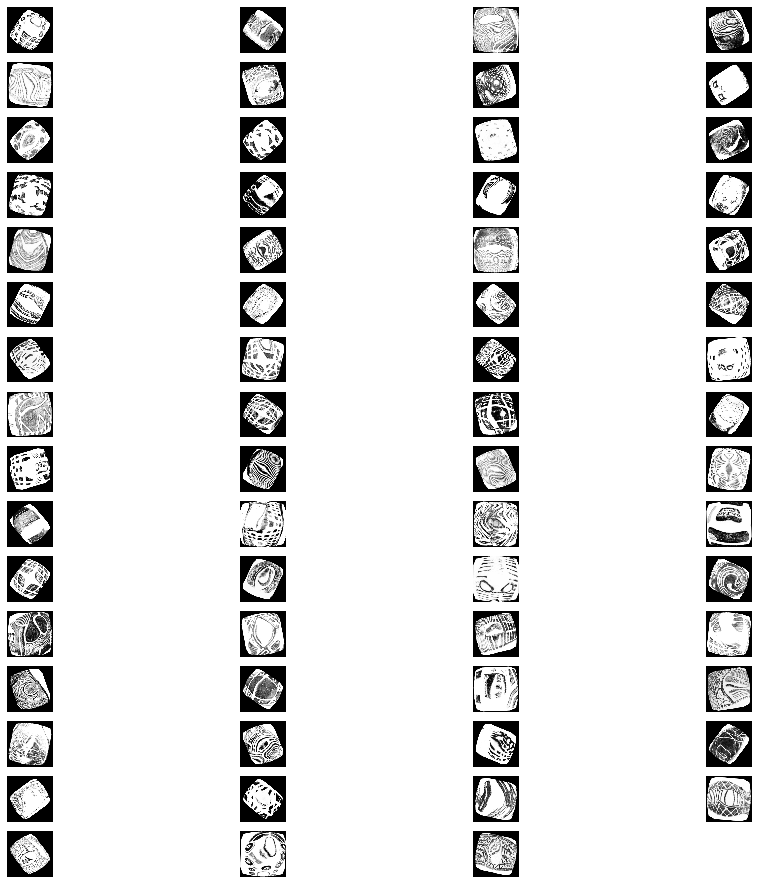

In [0]:
fetch_FID_300_data()
labels = load_labels()
organize_files(labels)
dataloaders_info = process_images()

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

model_ft, hist, train_hist, test_hist = train_model(model_ft, dataloaders_info, criterion, optimizer_ft, 
                             num_epochs=NUM_EPOCHS, is_inception=(MODEL_NAME=="inception"))

In [0]:

with open(MODEL_NAME+".csv", 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Epoch", "Train Accuracy", "Validation_Accuracy", "Test Accuracy"])
    for i, (val_acc, train_acc, test_acc) in enumerate(zip(hist, train_hist, test_hist)):
      writer.writerow([i, train_acc, val_acc, test_acc])

with open(MODEL_NAME+".csv") as f:
  print(f.read())
